---
title: "Implementing Sparse Autoencoders from Scratch"
date: "2024-09-08"
description: "We will be coding a basic Sparse Autoencoder (SAE) in pytorch and training it on the MNIST dataset."
bibliography: references.bib
---

## Need for Unsupervised Techniques
As you might have heard, the power of deep-learning often times is not merely in the results that the deep models are capable of generating but largely in the representations that they learn. 

Before the deep learning revolution (that most people believe occurred with @krizhevsky2012imagenet), experts would hand engineer features for domain specific tasks. These features could be various edge detection filters for vision tasks (Harris Corner Detector filter detects corners by gauging the change in pixel intensities) among others. However, as the complexity of the downstream tasks that we wanted to accomplish increased, this particular method for learning features did not scale so well. 

Then, the advent of unsupervised techniques for learning these features rather than hand crafting came to the fore. This shift in how we learn the features for some input distribution is one of the major breakthroughs in modern deep-learning. One particular class of such techniques is the autoencoder architecture. 

## The Autoencoder Architecture 

<div style="text-align: center;">
  <img src="encoder.png" alt="Autoencoder Architecture" style="width:80%;height:80%">
</div>

The autoencoder architecture does not require any carefully labelled data to learn representations for the input. In fact, all you really need is the input data itself. 

More conceretely, given an input $\mathbf{x} \in \mathbb{R}^n$, the **encoder** part of the autoencoder maps the input $\mathbf{x}$ to a latent representation $\mathbf{h} \in \mathbb{R}^m$. Consequently, the **decoder** part of the autoencoder then uses this latent represenation $\mathbf{h}$ to reconstruct the input $\mathbf{x}$. 

We can then tune the weights of both the whole autoencoder via **Gradient Descent** by seeing how far off the reconstructed version of the input is from the actual input. For gauging how far off the reconstruction is from the input, we can employ common loss functions such as the **mean squared error**. The better our reconstruction, the more potent our latent representation $\mathbf{h}$ (or features) become.

If you notice, the input $\mathbf{x}$ was part of $\mathbb{R}^n$ but the latent representation $\mathbf{h}$ is part of $\mathbb{R}^m$. We can then have two distinct cases:

1. **Over-complete case**: This is when $\mathbf{m} \ge \mathbf{n}$. This case is prone to a major issue that we peek into in the subsequent section.

2. **Under-complete case**: This is when $\mathbf{m} \lt \mathbf{n}$.

## Need for Regularisation in Autoencoders
As foreshadowed in the previous section, the over-complete autoencoders have greater capacity (more neurons) in the latent representation layer $\mathbf{h}$ than the number of features in the input $\mathbf{x}$. This can lead to one major issue:

The nature of the objective in the autoencoder setting (low error reconstruction of the input data) means that the autoencoder with a large latent space capacity can naively learn to 'copy' the input features into the latent space instead of learning new, useful features and still display an incredibly low loss. This is a severe case of overfitting where our network memorises the input data and will suffer to generalise outside of the training domain. 

Although this case ususally arises in the over-complete case, it is also possible in the under-complete case given the distribution of the input data is rather simple. 

But the question then is: **How do we avoid this catastrophic over-fitting?**. A simple answer would be **Regularisation**. 

More specifically, we will be looking into the sparsity contraint which is a form of regularisation that gives rise to the Sparse Autoencoder (SAE).

# The Sparse Autoencoder (SAE)

<div style="text-align: center;">
  <img src="sae.png" alt="Autoencoder Architecture" style="width:80%;height:80%">
</div>

The main idea behind the SAE is that instead of allowing all the $\mathbf{m}$ neurons in the latent space $\mathbf{h}$ fire completely, we would like these neurons on average to be activated only upto a level $\rho$ for a given batch of inputs.

In the subsequent sections, we will be doing the following:

1. **Build an SAE step-by-step from scratch in Pytorch.**

2. **Train our SAE on the MNIST dataset.**

3. **See how well our SAE is able to reconstruct the MNIST dataset (i.e., numbers from 0-9).**

### Importing the Data 

In [1]:
import os
import argparse
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [66]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [2]:
BATCH_SIZE = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download= True
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size= BATCH_SIZE,
    shuffle=True
)

val_dataset = datasets.MNIST(
    root='./data',
    train=False,  # Use the test set as validation set
    transform=transform,
    download=True
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [06:20<00:00, 26040.58it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 31908.37it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [01:04<00:00, 25719.19it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 15999.10it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Building the Encoder
Once we recieve the input data of shape $(batch\_size, 1, 28, 28)$, we will first have to flatten it into a vector of shape $(batch\_size, 1* 28 *28) = (batch\_size, 784)$.

Then, this flattened vector will pass through the encoder network. The encoder network in our case is just a simple feed-forward network with ReLU activations sandwiched between linear layers. The final output vector from the encoder network will be our latent representation $\mathbf{h}$ for the input. 




A simple, single layered under-complete encoder would look like this:

In [28]:
images, _ = next(iter(train_dataloader))

print(f'images shape: {images.shape}')
flat_images = images.view(images.shape[0], -1) # Convert the images tensor into a vector

print(f'Flattened images vector shape: {flat_images.shape}')

images shape: torch.Size([64, 1, 28, 28])
Flattened images vector shape: torch.Size([64, 784])


In [31]:
# A simple single layered encoder. The size of h = 20 (i.e., 20 neurons in the latent space so its an undercomplete autoencoder)
encoder = nn.Sequential(
    nn.Linear(28*28, 20),
    nn.ReLU()
)
encoded = encoder(flat_images)
print(f'Shape of encoded images: {encoded.shape}')

Shape of encoded images: torch.Size([64, 20])


On the other hand, a more complex under-complete encoder could have mutliple linear layers with non-linearities in between:

In [40]:
complex_encoder = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 20),
    nn.ReLU()
)

encoded = complex_encoder(flat_images)
print(f'Shape of encoded images: {encoded.shape}')

Shape of encoded images: torch.Size([64, 20])


The latent representations for the first 5 of these 64 input images look something like this: 

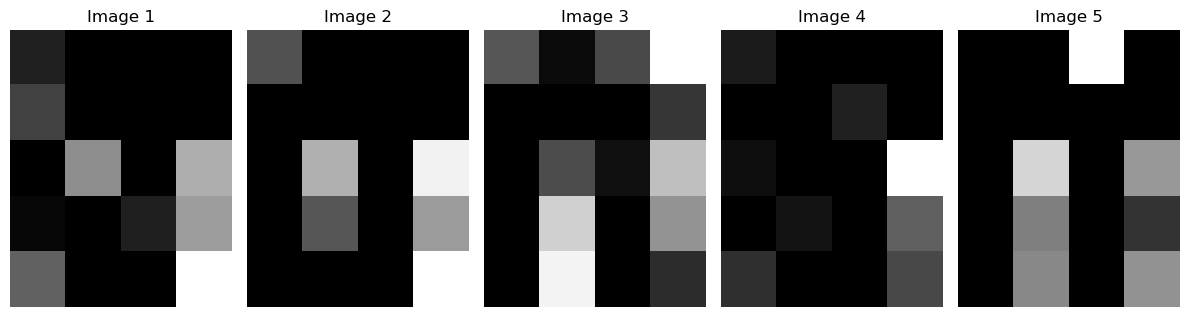

In [46]:
# Converting tensor to numpy array 
encoded_np = encoded.detach().numpy()

# Reshaping each vector to 2D image dimensions (e.g., 5x4) for visualization
num_images = 5
image_height = 5
image_width = 4

# Plotting the first 5 latent representations
plt.figure(figsize=(12, 6))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    image = encoded_np[i].reshape(image_height, image_width)
    plt.imshow(image, cmap='gray')
    plt.title(f'Image {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Understanding the Sparsity Contraint

Before we move on to the decoder, we need to get a grip over what exactly the sparsity constraint is.

As I mentioned earlier, we pick a hyper-parameter called $\rho$ which decides that for a given batch of input images, how activated on average should each of the $\mathbf{m}$ neurons in the latent representation $\mathbf{h}$ be. 

Putting it mathematically, we have the following set of simple equations:

$$\hat{\rho}_i = \frac{1}{N} \sum_{i=1}^N h_i(x)$$

Here $\hat{\rho}_i$ represents the average activation of the $i^{th}$ latent space neuron over a batch of input data with $N$ elements.

Now, the sparsity contraint says that we need to push the value of $\hat{\rho}_i$ close to $\rho$ for all $i \in \{1,2, \dots, m\}$ in the latent space. 

A simple way to measure how far off a particular distribution is from some reference distribution is to use the KL-divergence. In our case, we need to measure how far off $\hat{\rho}$ is from $\rho$:

$$\sum_{i=1}^m [\rho \log \frac{\rho}{\hat{\rho}_i} + (1-\rho) \log \frac{1-\rho}{1-\hat{\rho}_i}] $$

This can be represented as:

$$\sum_{i=1}^m \text{KL}(\rho \| \hat{\rho}_i)$$


Now let's code up the sparsity penalty. I would like you to quickly take note of a these three implementation details:

1. **Shape of $\rho$ and $\hat{\rho}$**: Since we average across the batch, the batch dimension will simply collapse so the $\hat{\rho}$ vector of an encoded vector of shape $(batch\_size, 20)$ would be of shape $(20,)$. 

2. **Sparsity target:** This is nothing but the $\rho$ value. 

3. **Sparsity lambda:** This is a multiplier that we use to scale up/down the sparsity penalty. Larger **sparsity lambda** values mean a larger penalty in case $\hat{\rho}$ deviates from $\rho$.

In [44]:
sparsity_target = 1e-3
sparsity_lambda = 2e-2

rho_hat = encoded.mean(dim=0) # Average activation of each neuron across the input batch 
rho = torch.ones_like(rho_hat) * sparsity_target # The rho vector we can to converge rho_hat towards

# Adding a small epsilon to rho_hat and rho to prevent log(0) errors
rho_hat = rho_hat + 1e-8
rho = rho + 1e-8

print(f'Rho shape: {rho.shape} || Rho hat shape: {rho_hat.shape}')

kl_div = - (rho * torch.log(rho_hat)) - ((1-rho) * torch.log(1-rho_hat))
penalty = sparsity_lambda * kl_div.sum()

print(f'Sparsity Penalty: {penalty:.4f}')

Rho shape: torch.Size([20]) || Rho hat shape: torch.Size([20])
Sparsity Penalty: 0.0159


### Building the Decoder 
Now that we have built the **Encoder** and also hopefully understood the **sparsity constraint**, we can move on to the final piece of our architecture, the **Decoder**.

As discussed earlier, the **Decoder** takes the latent representation $\mathbf{h}$ as input and reconstructs the input data $\mathbf{x}$.

For the sake of convenience, I will define the **Decoder** architecture simply as the inverse of the encoder architecture in case the encoder architecture has multiple layers. This means if the encoder had linear layers of shapes $[784, 256, 128, 20]$ then the decoder would have layers with the shape $[20, 128, 256, 784]$.  

In [45]:
complex_decoder = nn.Sequential(
    nn.Linear(20, 128),
    nn.ReLU(),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Linear(256, 784),
)

decoded = complex_decoder(encoded)
print(f'Deocded shape: {decoded.shape}')

Deocded shape: torch.Size([64, 784])


Now since the encoder and the decoder have completely random weights at this stage, we should expect the reconstructed images from the autoencoder to be completely noisy (should look something like static noise). 

But, in the final section when we actually train the model, you will see how beautifully the latent space captures the features of the input distribution and hence leads to some promising reconstructions!

Shape of images: (64, 28, 28)


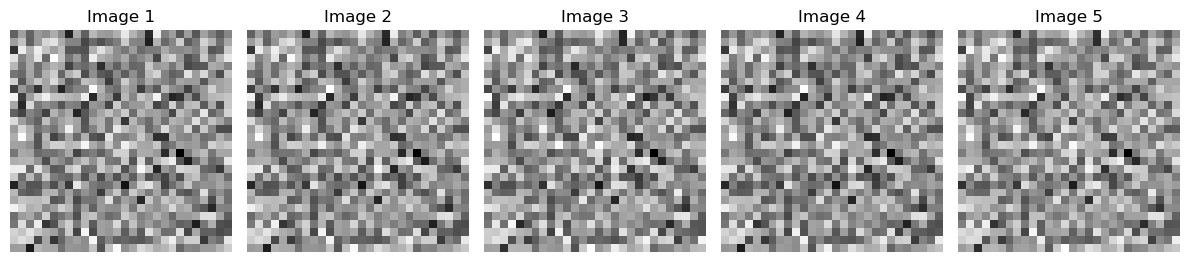

In [60]:
# Converting tensor to numpy array 
untrained_images = decoded.view(64, 28, 28).detach().numpy()

print(f'Shape of images: {untrained_images.shape}')

num_images = 5
image_height = 28
image_width = 28

# Plotting the first 5 latent representations
plt.figure(figsize=(12, 6))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    image = untrained_images[i].reshape(image_height, image_width)
    plt.imshow(image, cmap='gray')
    plt.title(f'Image {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Reconstruction Error
Ok, before we move on to combining the bits and pieces into a full-fledged SAE architecture, we need to understand the reconstruction error. We essentially need to measure the following:

**How far off is my reconstructed image from the actual input image?** 

In our case, we can measure this using the Mean Squared Error (MSE). The final loss of our SAE model will be a sum of MSE and the Sparsity Penalty. 

In [59]:
MSE_loss = F.mse_loss(decoded, flat_images)
print(f'MSE Loss: {MSE_loss.item():.4f}')

MSE Loss: 0.9892


### Putting Everything Together
In this section, we will simply stitch together the bits and pieces from all the sections and finally train our SAE on MNIST. Let's see how far our training takes us from our initial noisy reconstructions ... 

In [62]:
class SAE(nn.Module):
    def __init__(self, in_dims, h_dims, sparsity_target, sparsity_lambda):
        super().__init__()
        self.in_dims = in_dims
        self.h_dims = h_dims
        self.sparsity_target = sparsity_target
        self.sparsity_lambda = sparsity_lambda
        
        """
        Encoder maps the input to a high/low dimensional latent space depending on the kind of AE being used.
        In the over-complete case, latent space is higher dimensional than input space while in the under-complete
        case, the opposite is true. The sparsity in the SAE generally allows the AE to learn a useful latent representation 
        even in the over-complete case by ensuring that the AE does not learn to naively 'copy' the input into the 
        higher dimensional latent space. We will be using the ReLU non-linearity between the encoder layers. 
        """
        
        self.enc_layers = [nn.Linear(self.in_dims, self.h_dims[0]), nn.ReLU()]
        
        for i in range(1, len(self.h_dims)):
            self.enc_layers.append(nn.Linear(self.h_dims[i - 1], self.h_dims[i]))
            self.enc_layers.append(nn.ReLU())

        """
        The decoder on the other hand uses the latent space representation of the input and tries to reconstruct
        the input. In this case, I will assume the decoder follows a reverse structure of layers compared to the 
        decoder. 
        """
        
        if len(self.h_dims) > 1:
            self.dec_layers = [nn.Linear(self.h_dims[-1], self.h_dims[-2]), nn.ReLU()]

            # Reverse the order of hidden layers for decoding
            for i in range(len(self.h_dims) - 2, 0, -1):
                self.dec_layers.append(nn.Linear(self.h_dims[i], self.h_dims[i - 1]))
                self.dec_layers.append(nn.ReLU())

            # Final layer to reconstruct the input dimensions
            self.dec_layers.append(nn.Linear(self.h_dims[0], self.in_dims))
            
        else:
            self.dec_layers = [nn.Linear(self.h_dims[-1], self.in_dims)]          

        self.encoder = nn.Sequential(*self.enc_layers)
        self.decoder = nn.Sequential(*self.dec_layers)

    def forward(self, x):
        # flatten x into a vector 
        x = x.view(x.shape[0], -1) # (batch_size, in_dim)
        
        encoded = self.encoder(x) # Push the input into the latent space (i.e., encode it)        
        decoded = self.decoder(encoded) # Reconstruct the input back from the latent space (i.e., decode it)
        
        return encoded, decoded
    
    def penalty(self, encoded):
        """
        This is the sparsity penalty. This adds a contraint on the activation values of the neurons in 
        the latent space by forcing them to be on average centered around some target sparsity level.
        This contraint prevents the latent space from simply being a naive copy of the input especially 
        in the over-complete case. 
        Generally, the KL divergence between the target sparsity vector and average latent space activation 
        vector is used to implement the penalty. 
        """
        
        data_rho = encoded.mean(dim=0) + 1e-8 # Average activation of each neuron across the input batch 
        rho = (torch.ones_like(data_rho) * self.sparsity_target) + 1e-8
        
        kl_div = - (rho * torch.log(data_rho)) - ((1-rho) * torch.log(1-data_rho))
        penalty = self.sparsity_lambda * kl_div.sum()
        
        return penalty
    
    def loss(self, x, decoded, encoded):
        x = x.view(x.shape[0], -1)
        mse_loss = F.mse_loss(decoded, x)
        sparsity_penalty = self.penalty(encoded)
        
        return mse_loss + sparsity_penalty
    
    def sample(self, x):
        
        torch.no_grad()
        x = x.view(x.shape[0], -1)  # Flatten the input to (batch_size, in_dim)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

In [63]:
def train_model(model, train_dataloader, n_epochs, optimizer, device):
    train_losses = []
    
    model.to(device)
    
    for epoch in range(n_epochs):
        model.train()
        total_train_loss = 0
        # Training loop
        for data, _ in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{n_epochs}"):
            data = data.to(device)
            optimizer.zero_grad()
            encoded, decoded = model(data)
            
            loss = model.loss(data, decoded, encoded)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
        
        # Calculate average training loss
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        print(f'\nEpoch: {epoch+1}/{n_epochs} -- Train Loss: {avg_train_loss:.4f}')
        print('-'*50)

    return train_losses


In [72]:
def plot_images(model, dataloader, device, num_images, save_plot):
    image, _ = next(iter(dataloader))[:num_images]
    image = image.to(device)
    reconstructed = model.sample(image)

    reconstructed = reconstructed.cpu().detach().numpy()
    image = image.cpu().numpy()

    # Plot original and reconstructed images side by side
    fig, axes = plt.subplots(2, num_images, figsize=(15 , 6))

    for i in range(num_images):
        # Plot original images
        ax = axes[0, i]
        ax.imshow(image[i].reshape(28, 28), cmap='gray')
        ax.set_title('Original')
        ax.axis('off')

        # Plot reconstructed images
        ax = axes[1, i]
        ax.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        ax.set_title('Reconstructed')
        ax.axis('off')

    plt.tight_layout()

    if save_plot:
        # Create 'images' directory if it does not exist
        if not os.path.exists('./images'):
            os.makedirs('./images')
        
        # Save the plot to 'images/plot.png'
        plt.savefig('images/plot.png')
    
    plt.show()

Hopefully none of the things in the **SAE class** look unfamiliar since we have discussed each component of the class before. Now, let's first initialise a SAE model, then train it and finally visualise the results.

In [68]:
set_seed()

model = SAE(784, [256, 128, 20], 1e-3, 3e-2)

epochs = 80
lr = 3e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device = torch.device('cpu')

train_losses  = train_model(model, train_dataloader, epochs, optimizer, device)

Epoch 1/80: 100%|██████████| 938/938 [00:05<00:00, 181.28it/s]



Epoch: 1/80 -- Train Loss: 0.6318
--------------------------------------------------


Epoch 2/80: 100%|██████████| 938/938 [00:04<00:00, 194.38it/s]



Epoch: 2/80 -- Train Loss: 0.4717
--------------------------------------------------


Epoch 3/80: 100%|██████████| 938/938 [00:04<00:00, 195.81it/s]



Epoch: 3/80 -- Train Loss: 0.4031
--------------------------------------------------


Epoch 4/80: 100%|██████████| 938/938 [00:05<00:00, 174.81it/s]



Epoch: 4/80 -- Train Loss: 0.3630
--------------------------------------------------


Epoch 5/80: 100%|██████████| 938/938 [00:04<00:00, 194.68it/s]



Epoch: 5/80 -- Train Loss: 0.3315
--------------------------------------------------


Epoch 6/80: 100%|██████████| 938/938 [00:04<00:00, 197.29it/s]



Epoch: 6/80 -- Train Loss: 0.3128
--------------------------------------------------


Epoch 7/80: 100%|██████████| 938/938 [00:04<00:00, 195.35it/s]



Epoch: 7/80 -- Train Loss: 0.2996
--------------------------------------------------


Epoch 8/80: 100%|██████████| 938/938 [00:04<00:00, 195.11it/s]



Epoch: 8/80 -- Train Loss: 0.2881
--------------------------------------------------


Epoch 9/80: 100%|██████████| 938/938 [00:04<00:00, 190.29it/s]



Epoch: 9/80 -- Train Loss: 0.2789
--------------------------------------------------


Epoch 10/80: 100%|██████████| 938/938 [00:05<00:00, 178.49it/s]



Epoch: 10/80 -- Train Loss: 0.2718
--------------------------------------------------


Epoch 11/80: 100%|██████████| 938/938 [00:05<00:00, 182.95it/s]



Epoch: 11/80 -- Train Loss: 0.2659
--------------------------------------------------


Epoch 12/80: 100%|██████████| 938/938 [00:05<00:00, 164.95it/s]



Epoch: 12/80 -- Train Loss: 0.2609
--------------------------------------------------


Epoch 13/80: 100%|██████████| 938/938 [00:05<00:00, 178.78it/s]



Epoch: 13/80 -- Train Loss: 0.2565
--------------------------------------------------


Epoch 14/80: 100%|██████████| 938/938 [00:05<00:00, 175.69it/s]



Epoch: 14/80 -- Train Loss: 0.2530
--------------------------------------------------


Epoch 15/80: 100%|██████████| 938/938 [00:05<00:00, 172.32it/s]



Epoch: 15/80 -- Train Loss: 0.2494
--------------------------------------------------


Epoch 16/80: 100%|██████████| 938/938 [00:05<00:00, 175.09it/s]



Epoch: 16/80 -- Train Loss: 0.2464
--------------------------------------------------


Epoch 17/80: 100%|██████████| 938/938 [00:05<00:00, 174.18it/s]



Epoch: 17/80 -- Train Loss: 0.2437
--------------------------------------------------


Epoch 18/80: 100%|██████████| 938/938 [00:05<00:00, 168.45it/s]



Epoch: 18/80 -- Train Loss: 0.2412
--------------------------------------------------


Epoch 19/80: 100%|██████████| 938/938 [00:05<00:00, 170.91it/s]



Epoch: 19/80 -- Train Loss: 0.2389
--------------------------------------------------


Epoch 20/80: 100%|██████████| 938/938 [00:05<00:00, 172.50it/s]



Epoch: 20/80 -- Train Loss: 0.2371
--------------------------------------------------


Epoch 21/80: 100%|██████████| 938/938 [00:05<00:00, 160.86it/s]



Epoch: 21/80 -- Train Loss: 0.2346
--------------------------------------------------


Epoch 22/80: 100%|██████████| 938/938 [00:05<00:00, 164.76it/s]



Epoch: 22/80 -- Train Loss: 0.2319
--------------------------------------------------


Epoch 23/80: 100%|██████████| 938/938 [00:05<00:00, 166.63it/s]



Epoch: 23/80 -- Train Loss: 0.2292
--------------------------------------------------


Epoch 24/80: 100%|██████████| 938/938 [00:05<00:00, 168.12it/s]



Epoch: 24/80 -- Train Loss: 0.2269
--------------------------------------------------


Epoch 25/80: 100%|██████████| 938/938 [00:05<00:00, 164.56it/s]



Epoch: 25/80 -- Train Loss: 0.2248
--------------------------------------------------


Epoch 26/80: 100%|██████████| 938/938 [00:05<00:00, 165.68it/s]



Epoch: 26/80 -- Train Loss: 0.2226
--------------------------------------------------


Epoch 27/80: 100%|██████████| 938/938 [00:05<00:00, 164.63it/s]



Epoch: 27/80 -- Train Loss: 0.2203
--------------------------------------------------


Epoch 28/80: 100%|██████████| 938/938 [00:05<00:00, 166.43it/s]



Epoch: 28/80 -- Train Loss: 0.2180
--------------------------------------------------


Epoch 29/80: 100%|██████████| 938/938 [00:05<00:00, 166.70it/s]



Epoch: 29/80 -- Train Loss: 0.2162
--------------------------------------------------


Epoch 30/80: 100%|██████████| 938/938 [00:05<00:00, 165.14it/s]



Epoch: 30/80 -- Train Loss: 0.2145
--------------------------------------------------


Epoch 31/80: 100%|██████████| 938/938 [00:05<00:00, 164.07it/s]



Epoch: 31/80 -- Train Loss: 0.2130
--------------------------------------------------


Epoch 32/80: 100%|██████████| 938/938 [00:05<00:00, 168.54it/s]



Epoch: 32/80 -- Train Loss: 0.2116
--------------------------------------------------


Epoch 33/80: 100%|██████████| 938/938 [00:05<00:00, 160.63it/s]



Epoch: 33/80 -- Train Loss: 0.2103
--------------------------------------------------


Epoch 34/80: 100%|██████████| 938/938 [00:05<00:00, 163.08it/s]



Epoch: 34/80 -- Train Loss: 0.2090
--------------------------------------------------


Epoch 35/80: 100%|██████████| 938/938 [00:05<00:00, 161.42it/s]



Epoch: 35/80 -- Train Loss: 0.2078
--------------------------------------------------


Epoch 36/80: 100%|██████████| 938/938 [00:05<00:00, 163.56it/s]



Epoch: 36/80 -- Train Loss: 0.2067
--------------------------------------------------


Epoch 37/80: 100%|██████████| 938/938 [00:05<00:00, 167.25it/s]



Epoch: 37/80 -- Train Loss: 0.2056
--------------------------------------------------


Epoch 38/80: 100%|██████████| 938/938 [00:05<00:00, 168.78it/s]



Epoch: 38/80 -- Train Loss: 0.2047
--------------------------------------------------


Epoch 39/80: 100%|██████████| 938/938 [00:05<00:00, 164.40it/s]



Epoch: 39/80 -- Train Loss: 0.2034
--------------------------------------------------


Epoch 40/80: 100%|██████████| 938/938 [00:05<00:00, 161.36it/s]



Epoch: 40/80 -- Train Loss: 0.2024
--------------------------------------------------


Epoch 41/80: 100%|██████████| 938/938 [00:05<00:00, 164.95it/s]



Epoch: 41/80 -- Train Loss: 0.2015
--------------------------------------------------


Epoch 42/80: 100%|██████████| 938/938 [00:05<00:00, 163.41it/s]



Epoch: 42/80 -- Train Loss: 0.2006
--------------------------------------------------


Epoch 43/80: 100%|██████████| 938/938 [00:05<00:00, 164.01it/s]



Epoch: 43/80 -- Train Loss: 0.1999
--------------------------------------------------


Epoch 44/80: 100%|██████████| 938/938 [00:05<00:00, 159.84it/s]



Epoch: 44/80 -- Train Loss: 0.1990
--------------------------------------------------


Epoch 45/80: 100%|██████████| 938/938 [00:05<00:00, 160.58it/s]



Epoch: 45/80 -- Train Loss: 0.1982
--------------------------------------------------


Epoch 46/80: 100%|██████████| 938/938 [00:05<00:00, 159.97it/s]



Epoch: 46/80 -- Train Loss: 0.1976
--------------------------------------------------


Epoch 47/80: 100%|██████████| 938/938 [00:05<00:00, 160.43it/s]



Epoch: 47/80 -- Train Loss: 0.1968
--------------------------------------------------


Epoch 48/80: 100%|██████████| 938/938 [00:06<00:00, 143.85it/s]



Epoch: 48/80 -- Train Loss: 0.1961
--------------------------------------------------


Epoch 49/80: 100%|██████████| 938/938 [00:05<00:00, 160.24it/s]



Epoch: 49/80 -- Train Loss: 0.1954
--------------------------------------------------


Epoch 50/80: 100%|██████████| 938/938 [00:05<00:00, 161.25it/s]



Epoch: 50/80 -- Train Loss: 0.1948
--------------------------------------------------


Epoch 51/80: 100%|██████████| 938/938 [00:05<00:00, 162.08it/s]



Epoch: 51/80 -- Train Loss: 0.1942
--------------------------------------------------


Epoch 52/80: 100%|██████████| 938/938 [00:05<00:00, 159.26it/s]



Epoch: 52/80 -- Train Loss: 0.1936
--------------------------------------------------


Epoch 53/80: 100%|██████████| 938/938 [00:05<00:00, 161.30it/s]



Epoch: 53/80 -- Train Loss: 0.1930
--------------------------------------------------


Epoch 54/80: 100%|██████████| 938/938 [00:06<00:00, 153.67it/s]



Epoch: 54/80 -- Train Loss: 0.1922
--------------------------------------------------


Epoch 55/80: 100%|██████████| 938/938 [00:05<00:00, 160.90it/s]



Epoch: 55/80 -- Train Loss: 0.1915
--------------------------------------------------


Epoch 56/80: 100%|██████████| 938/938 [00:05<00:00, 160.44it/s]



Epoch: 56/80 -- Train Loss: 0.1909
--------------------------------------------------


Epoch 57/80: 100%|██████████| 938/938 [00:05<00:00, 159.12it/s]



Epoch: 57/80 -- Train Loss: 0.1904
--------------------------------------------------


Epoch 58/80: 100%|██████████| 938/938 [00:06<00:00, 148.96it/s]



Epoch: 58/80 -- Train Loss: 0.1898
--------------------------------------------------


Epoch 59/80: 100%|██████████| 938/938 [00:05<00:00, 158.44it/s]



Epoch: 59/80 -- Train Loss: 0.1891
--------------------------------------------------


Epoch 60/80: 100%|██████████| 938/938 [00:05<00:00, 157.97it/s]



Epoch: 60/80 -- Train Loss: 0.1884
--------------------------------------------------


Epoch 61/80: 100%|██████████| 938/938 [00:05<00:00, 157.66it/s]



Epoch: 61/80 -- Train Loss: 0.1875
--------------------------------------------------


Epoch 62/80: 100%|██████████| 938/938 [00:05<00:00, 158.33it/s]



Epoch: 62/80 -- Train Loss: 0.1865
--------------------------------------------------


Epoch 63/80: 100%|██████████| 938/938 [00:05<00:00, 160.25it/s]



Epoch: 63/80 -- Train Loss: 0.1853
--------------------------------------------------


Epoch 64/80: 100%|██████████| 938/938 [00:06<00:00, 154.78it/s]



Epoch: 64/80 -- Train Loss: 0.1845
--------------------------------------------------


Epoch 65/80: 100%|██████████| 938/938 [00:05<00:00, 157.46it/s]



Epoch: 65/80 -- Train Loss: 0.1836
--------------------------------------------------


Epoch 66/80: 100%|██████████| 938/938 [00:05<00:00, 161.59it/s]



Epoch: 66/80 -- Train Loss: 0.1829
--------------------------------------------------


Epoch 67/80: 100%|██████████| 938/938 [00:05<00:00, 160.56it/s]



Epoch: 67/80 -- Train Loss: 0.1822
--------------------------------------------------


Epoch 68/80: 100%|██████████| 938/938 [00:05<00:00, 162.73it/s]



Epoch: 68/80 -- Train Loss: 0.1815
--------------------------------------------------


Epoch 69/80: 100%|██████████| 938/938 [00:05<00:00, 159.04it/s]



Epoch: 69/80 -- Train Loss: 0.1810
--------------------------------------------------


Epoch 70/80: 100%|██████████| 938/938 [00:05<00:00, 158.72it/s]



Epoch: 70/80 -- Train Loss: 0.1802
--------------------------------------------------


Epoch 71/80: 100%|██████████| 938/938 [00:05<00:00, 158.58it/s]



Epoch: 71/80 -- Train Loss: 0.1797
--------------------------------------------------


Epoch 72/80: 100%|██████████| 938/938 [00:05<00:00, 158.18it/s]



Epoch: 72/80 -- Train Loss: 0.1792
--------------------------------------------------


Epoch 73/80: 100%|██████████| 938/938 [00:05<00:00, 158.52it/s]



Epoch: 73/80 -- Train Loss: 0.1786
--------------------------------------------------


Epoch 74/80: 100%|██████████| 938/938 [00:06<00:00, 155.61it/s]



Epoch: 74/80 -- Train Loss: 0.1781
--------------------------------------------------


Epoch 75/80: 100%|██████████| 938/938 [00:06<00:00, 155.55it/s]



Epoch: 75/80 -- Train Loss: 0.1775
--------------------------------------------------


Epoch 76/80: 100%|██████████| 938/938 [00:05<00:00, 156.91it/s]



Epoch: 76/80 -- Train Loss: 0.1771
--------------------------------------------------


Epoch 77/80: 100%|██████████| 938/938 [00:05<00:00, 159.50it/s]



Epoch: 77/80 -- Train Loss: 0.1766
--------------------------------------------------


Epoch 78/80: 100%|██████████| 938/938 [00:05<00:00, 156.44it/s]



Epoch: 78/80 -- Train Loss: 0.1762
--------------------------------------------------


Epoch 79/80: 100%|██████████| 938/938 [00:05<00:00, 157.26it/s]



Epoch: 79/80 -- Train Loss: 0.1756
--------------------------------------------------


Epoch 80/80: 100%|██████████| 938/938 [00:06<00:00, 140.10it/s]


Epoch: 80/80 -- Train Loss: 0.1753
--------------------------------------------------


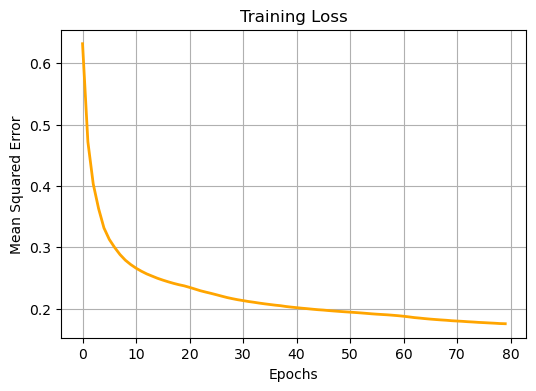

In [73]:
plt.figure(figsize=(6, 4))
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.plot(train_losses, color='orange', linewidth=2)
plt.grid(True)
plt.show()

Look how much better the image reconstructions have now become! Obviously, the longer we train for, the better the results get. 

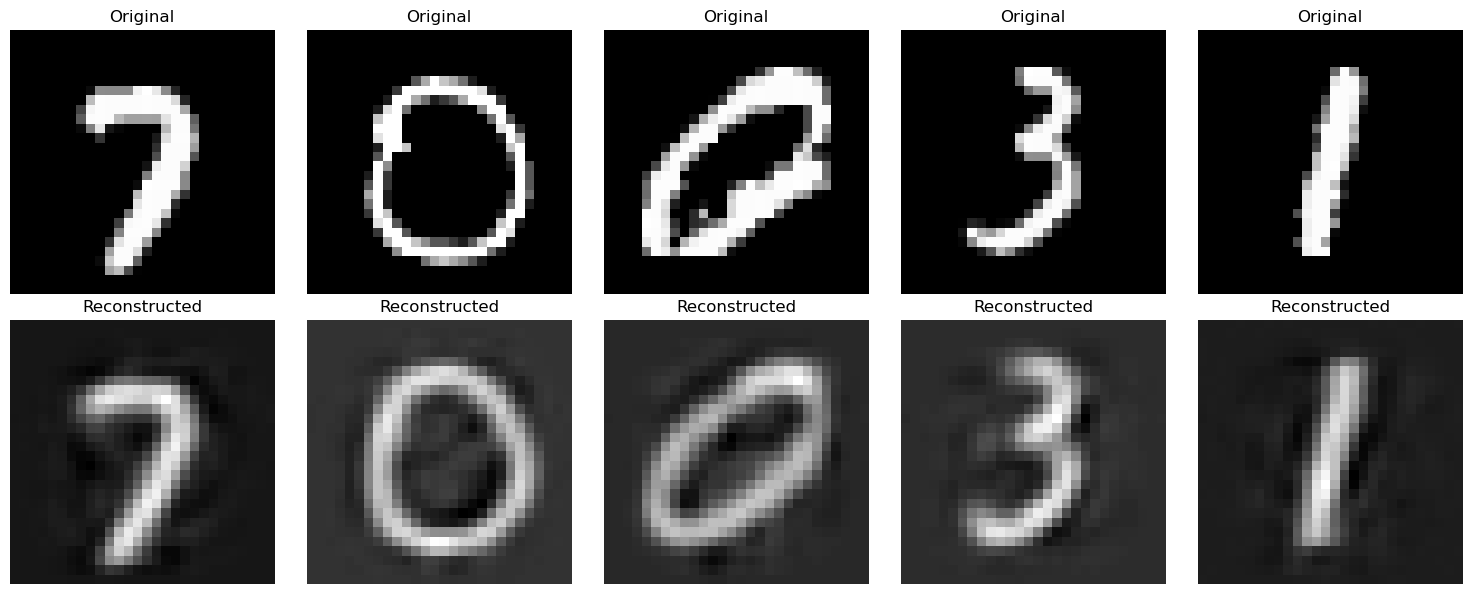

In [75]:
# Let's sample some images from the trained SAE and see far we have come!
plot_images(model, train_dataloader, device, 5, False)

If you noticed, the SAE that we just trained was a under-complete case, lets now move into a very simple over complete case and see how it fares!

In [77]:
set_seed()

overcomplete_model = SAE(784, [1024], 1e-3, 3e-2)

epochs = 80
lr = 1e-4
optimizer = torch.optim.Adam(overcomplete_model.parameters(), lr=lr)

# device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device = torch.device('cpu')

train_losses  = train_model(overcomplete_model, train_dataloader, epochs, optimizer, device)

Epoch 1/80:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/80: 100%|██████████| 938/938 [00:08<00:00, 115.04it/s]



Epoch: 1/80 -- Train Loss: 1.4328
--------------------------------------------------


Epoch 2/80: 100%|██████████| 938/938 [00:07<00:00, 119.59it/s]



Epoch: 2/80 -- Train Loss: 1.1536
--------------------------------------------------


Epoch 3/80: 100%|██████████| 938/938 [00:08<00:00, 109.76it/s]



Epoch: 3/80 -- Train Loss: 1.0151
--------------------------------------------------


Epoch 4/80: 100%|██████████| 938/938 [00:08<00:00, 106.89it/s]



Epoch: 4/80 -- Train Loss: 0.9386
--------------------------------------------------


Epoch 5/80: 100%|██████████| 938/938 [00:07<00:00, 117.38it/s]



Epoch: 5/80 -- Train Loss: 0.8905
--------------------------------------------------


Epoch 6/80: 100%|██████████| 938/938 [00:08<00:00, 116.39it/s]



Epoch: 6/80 -- Train Loss: 0.8526
--------------------------------------------------


Epoch 7/80: 100%|██████████| 938/938 [00:08<00:00, 113.50it/s]



Epoch: 7/80 -- Train Loss: 0.8288
--------------------------------------------------


Epoch 8/80: 100%|██████████| 938/938 [00:08<00:00, 105.02it/s]



Epoch: 8/80 -- Train Loss: 0.8013
--------------------------------------------------


Epoch 9/80: 100%|██████████| 938/938 [00:08<00:00, 111.01it/s]



Epoch: 9/80 -- Train Loss: 0.7795
--------------------------------------------------


Epoch 10/80: 100%|██████████| 938/938 [00:08<00:00, 112.55it/s]



Epoch: 10/80 -- Train Loss: 0.7603
--------------------------------------------------


Epoch 11/80: 100%|██████████| 938/938 [00:08<00:00, 111.33it/s]



Epoch: 11/80 -- Train Loss: 0.7524
--------------------------------------------------


Epoch 12/80: 100%|██████████| 938/938 [00:08<00:00, 112.71it/s]



Epoch: 12/80 -- Train Loss: 0.7317
--------------------------------------------------


Epoch 13/80: 100%|██████████| 938/938 [00:08<00:00, 111.93it/s]



Epoch: 13/80 -- Train Loss: 0.7284
--------------------------------------------------


Epoch 14/80: 100%|██████████| 938/938 [00:09<00:00, 100.70it/s]



Epoch: 14/80 -- Train Loss: 0.7195
--------------------------------------------------


Epoch 15/80: 100%|██████████| 938/938 [00:09<00:00, 101.48it/s]



Epoch: 15/80 -- Train Loss: 0.7130
--------------------------------------------------


Epoch 16/80: 100%|██████████| 938/938 [00:08<00:00, 111.45it/s]



Epoch: 16/80 -- Train Loss: 0.7054
--------------------------------------------------


Epoch 17/80: 100%|██████████| 938/938 [00:08<00:00, 105.15it/s]



Epoch: 17/80 -- Train Loss: 0.6976
--------------------------------------------------


Epoch 18/80: 100%|██████████| 938/938 [00:08<00:00, 112.27it/s]



Epoch: 18/80 -- Train Loss: 0.6920
--------------------------------------------------


Epoch 19/80: 100%|██████████| 938/938 [00:08<00:00, 113.31it/s]



Epoch: 19/80 -- Train Loss: 0.6832
--------------------------------------------------


Epoch 20/80: 100%|██████████| 938/938 [00:08<00:00, 112.05it/s]



Epoch: 20/80 -- Train Loss: 0.6778
--------------------------------------------------


Epoch 21/80: 100%|██████████| 938/938 [00:08<00:00, 111.44it/s]



Epoch: 21/80 -- Train Loss: 0.6838
--------------------------------------------------


Epoch 22/80: 100%|██████████| 938/938 [00:08<00:00, 111.65it/s]



Epoch: 22/80 -- Train Loss: 0.6745
--------------------------------------------------


Epoch 23/80: 100%|██████████| 938/938 [00:08<00:00, 109.62it/s]



Epoch: 23/80 -- Train Loss: 0.6696
--------------------------------------------------


Epoch 24/80: 100%|██████████| 938/938 [00:08<00:00, 111.22it/s]



Epoch: 24/80 -- Train Loss: 0.6674
--------------------------------------------------


Epoch 25/80: 100%|██████████| 938/938 [00:08<00:00, 110.82it/s]



Epoch: 25/80 -- Train Loss: 0.6696
--------------------------------------------------


Epoch 26/80: 100%|██████████| 938/938 [00:09<00:00, 96.43it/s] 



Epoch: 26/80 -- Train Loss: 0.6655
--------------------------------------------------


Epoch 27/80: 100%|██████████| 938/938 [00:08<00:00, 106.85it/s]



Epoch: 27/80 -- Train Loss: 0.6611
--------------------------------------------------


Epoch 28/80: 100%|██████████| 938/938 [00:08<00:00, 112.20it/s]



Epoch: 28/80 -- Train Loss: 0.6561
--------------------------------------------------


Epoch 29/80: 100%|██████████| 938/938 [00:08<00:00, 108.98it/s]



Epoch: 29/80 -- Train Loss: 0.6583
--------------------------------------------------


Epoch 30/80: 100%|██████████| 938/938 [00:08<00:00, 104.31it/s]



Epoch: 30/80 -- Train Loss: 0.6574
--------------------------------------------------


Epoch 31/80: 100%|██████████| 938/938 [00:08<00:00, 108.87it/s]



Epoch: 31/80 -- Train Loss: 0.6519
--------------------------------------------------


Epoch 32/80: 100%|██████████| 938/938 [00:09<00:00, 102.45it/s]



Epoch: 32/80 -- Train Loss: 0.6536
--------------------------------------------------


Epoch 33/80: 100%|██████████| 938/938 [00:08<00:00, 109.91it/s]



Epoch: 33/80 -- Train Loss: 0.6525
--------------------------------------------------


Epoch 34/80: 100%|██████████| 938/938 [00:08<00:00, 110.99it/s]



Epoch: 34/80 -- Train Loss: 0.6516
--------------------------------------------------


Epoch 35/80: 100%|██████████| 938/938 [00:08<00:00, 108.65it/s]



Epoch: 35/80 -- Train Loss: 0.6485
--------------------------------------------------


Epoch 36/80: 100%|██████████| 938/938 [00:08<00:00, 106.99it/s]



Epoch: 36/80 -- Train Loss: 0.6440
--------------------------------------------------


Epoch 37/80: 100%|██████████| 938/938 [00:08<00:00, 109.30it/s]



Epoch: 37/80 -- Train Loss: 0.6410
--------------------------------------------------


Epoch 38/80: 100%|██████████| 938/938 [00:08<00:00, 111.78it/s]



Epoch: 38/80 -- Train Loss: 0.6393
--------------------------------------------------


Epoch 39/80: 100%|██████████| 938/938 [00:08<00:00, 104.94it/s]



Epoch: 39/80 -- Train Loss: 0.6405
--------------------------------------------------


Epoch 40/80: 100%|██████████| 938/938 [00:09<00:00, 98.89it/s] 



Epoch: 40/80 -- Train Loss: 0.6436
--------------------------------------------------


Epoch 41/80: 100%|██████████| 938/938 [00:09<00:00, 101.48it/s]



Epoch: 41/80 -- Train Loss: 0.6365
--------------------------------------------------


Epoch 42/80: 100%|██████████| 938/938 [00:08<00:00, 105.37it/s]



Epoch: 42/80 -- Train Loss: 0.6371
--------------------------------------------------


Epoch 43/80: 100%|██████████| 938/938 [00:08<00:00, 107.56it/s]



Epoch: 43/80 -- Train Loss: 0.6364
--------------------------------------------------


Epoch 44/80: 100%|██████████| 938/938 [00:08<00:00, 109.42it/s]



Epoch: 44/80 -- Train Loss: 0.6325
--------------------------------------------------


Epoch 45/80: 100%|██████████| 938/938 [00:08<00:00, 108.85it/s]



Epoch: 45/80 -- Train Loss: 0.6341
--------------------------------------------------


Epoch 46/80: 100%|██████████| 938/938 [00:08<00:00, 108.24it/s]



Epoch: 46/80 -- Train Loss: 0.6349
--------------------------------------------------


Epoch 47/80: 100%|██████████| 938/938 [00:08<00:00, 105.68it/s]



Epoch: 47/80 -- Train Loss: 0.6374
--------------------------------------------------


Epoch 48/80: 100%|██████████| 938/938 [00:09<00:00, 103.48it/s]



Epoch: 48/80 -- Train Loss: 0.6339
--------------------------------------------------


Epoch 49/80: 100%|██████████| 938/938 [00:09<00:00, 101.69it/s]



Epoch: 49/80 -- Train Loss: 0.6311
--------------------------------------------------


Epoch 50/80: 100%|██████████| 938/938 [00:09<00:00, 102.08it/s]



Epoch: 50/80 -- Train Loss: 0.6356
--------------------------------------------------


Epoch 51/80: 100%|██████████| 938/938 [00:08<00:00, 109.20it/s]



Epoch: 51/80 -- Train Loss: 0.6330
--------------------------------------------------


Epoch 52/80: 100%|██████████| 938/938 [00:08<00:00, 109.82it/s]



Epoch: 52/80 -- Train Loss: 0.6280
--------------------------------------------------


Epoch 53/80: 100%|██████████| 938/938 [00:08<00:00, 109.70it/s]



Epoch: 53/80 -- Train Loss: 0.6293
--------------------------------------------------


Epoch 54/80: 100%|██████████| 938/938 [00:08<00:00, 109.17it/s]



Epoch: 54/80 -- Train Loss: 0.6304
--------------------------------------------------


Epoch 55/80: 100%|██████████| 938/938 [00:08<00:00, 110.15it/s]



Epoch: 55/80 -- Train Loss: 0.6278
--------------------------------------------------


Epoch 56/80: 100%|██████████| 938/938 [00:08<00:00, 109.93it/s]



Epoch: 56/80 -- Train Loss: 0.6340
--------------------------------------------------


Epoch 57/80: 100%|██████████| 938/938 [00:09<00:00, 99.92it/s] 



Epoch: 57/80 -- Train Loss: 0.6375
--------------------------------------------------


Epoch 58/80: 100%|██████████| 938/938 [00:09<00:00, 103.86it/s]



Epoch: 58/80 -- Train Loss: 0.6328
--------------------------------------------------


Epoch 59/80: 100%|██████████| 938/938 [00:09<00:00, 102.29it/s]



Epoch: 59/80 -- Train Loss: 0.6290
--------------------------------------------------


Epoch 60/80: 100%|██████████| 938/938 [00:09<00:00, 101.81it/s]



Epoch: 60/80 -- Train Loss: 0.6256
--------------------------------------------------


Epoch 61/80: 100%|██████████| 938/938 [00:09<00:00, 99.03it/s] 



Epoch: 61/80 -- Train Loss: 0.6256
--------------------------------------------------


Epoch 62/80: 100%|██████████| 938/938 [00:08<00:00, 108.02it/s]



Epoch: 62/80 -- Train Loss: 0.6230
--------------------------------------------------


Epoch 63/80: 100%|██████████| 938/938 [00:09<00:00, 101.12it/s]



Epoch: 63/80 -- Train Loss: 0.6251
--------------------------------------------------


Epoch 64/80: 100%|██████████| 938/938 [00:09<00:00, 95.23it/s] 



Epoch: 64/80 -- Train Loss: 0.6246
--------------------------------------------------


Epoch 65/80: 100%|██████████| 938/938 [00:11<00:00, 83.55it/s] 



Epoch: 65/80 -- Train Loss: 0.6267
--------------------------------------------------


Epoch 66/80: 100%|██████████| 938/938 [00:08<00:00, 104.23it/s]



Epoch: 66/80 -- Train Loss: 0.6200
--------------------------------------------------


Epoch 67/80: 100%|██████████| 938/938 [00:08<00:00, 109.93it/s]



Epoch: 67/80 -- Train Loss: 0.6293
--------------------------------------------------


Epoch 68/80: 100%|██████████| 938/938 [00:08<00:00, 108.93it/s]



Epoch: 68/80 -- Train Loss: 0.6249
--------------------------------------------------


Epoch 69/80: 100%|██████████| 938/938 [00:08<00:00, 106.84it/s]



Epoch: 69/80 -- Train Loss: 0.6249
--------------------------------------------------


Epoch 70/80: 100%|██████████| 938/938 [00:08<00:00, 107.53it/s]



Epoch: 70/80 -- Train Loss: 0.6214
--------------------------------------------------


Epoch 71/80: 100%|██████████| 938/938 [00:08<00:00, 106.18it/s]



Epoch: 71/80 -- Train Loss: 0.6217
--------------------------------------------------


Epoch 72/80: 100%|██████████| 938/938 [00:09<00:00, 103.50it/s]



Epoch: 72/80 -- Train Loss: 0.6181
--------------------------------------------------


Epoch 73/80: 100%|██████████| 938/938 [00:08<00:00, 104.41it/s]



Epoch: 73/80 -- Train Loss: 0.6224
--------------------------------------------------


Epoch 74/80: 100%|██████████| 938/938 [00:08<00:00, 108.77it/s]



Epoch: 74/80 -- Train Loss: 0.6266
--------------------------------------------------


Epoch 75/80: 100%|██████████| 938/938 [00:09<00:00, 103.78it/s]



Epoch: 75/80 -- Train Loss: 0.6254
--------------------------------------------------


Epoch 76/80: 100%|██████████| 938/938 [00:08<00:00, 110.50it/s]



Epoch: 76/80 -- Train Loss: 0.6186
--------------------------------------------------


Epoch 77/80: 100%|██████████| 938/938 [00:09<00:00, 103.54it/s]



Epoch: 77/80 -- Train Loss: 0.6248
--------------------------------------------------


Epoch 78/80: 100%|██████████| 938/938 [00:08<00:00, 104.45it/s]



Epoch: 78/80 -- Train Loss: 0.6217
--------------------------------------------------


Epoch 79/80: 100%|██████████| 938/938 [00:08<00:00, 106.48it/s]



Epoch: 79/80 -- Train Loss: 0.6250
--------------------------------------------------


Epoch 80/80: 100%|██████████| 938/938 [00:08<00:00, 105.42it/s]


Epoch: 80/80 -- Train Loss: 0.6249
--------------------------------------------------


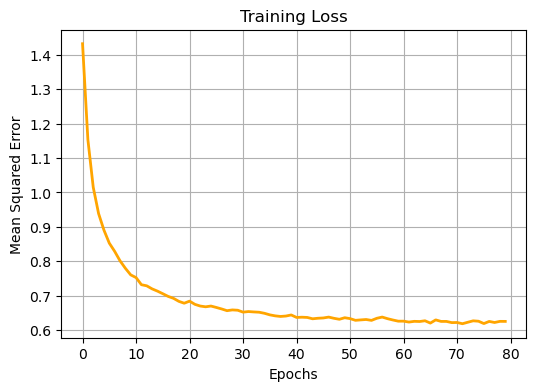

In [78]:
plt.figure(figsize=(6, 4))
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.plot(train_losses, color='orange', linewidth=2)
plt.grid(True)
plt.show()

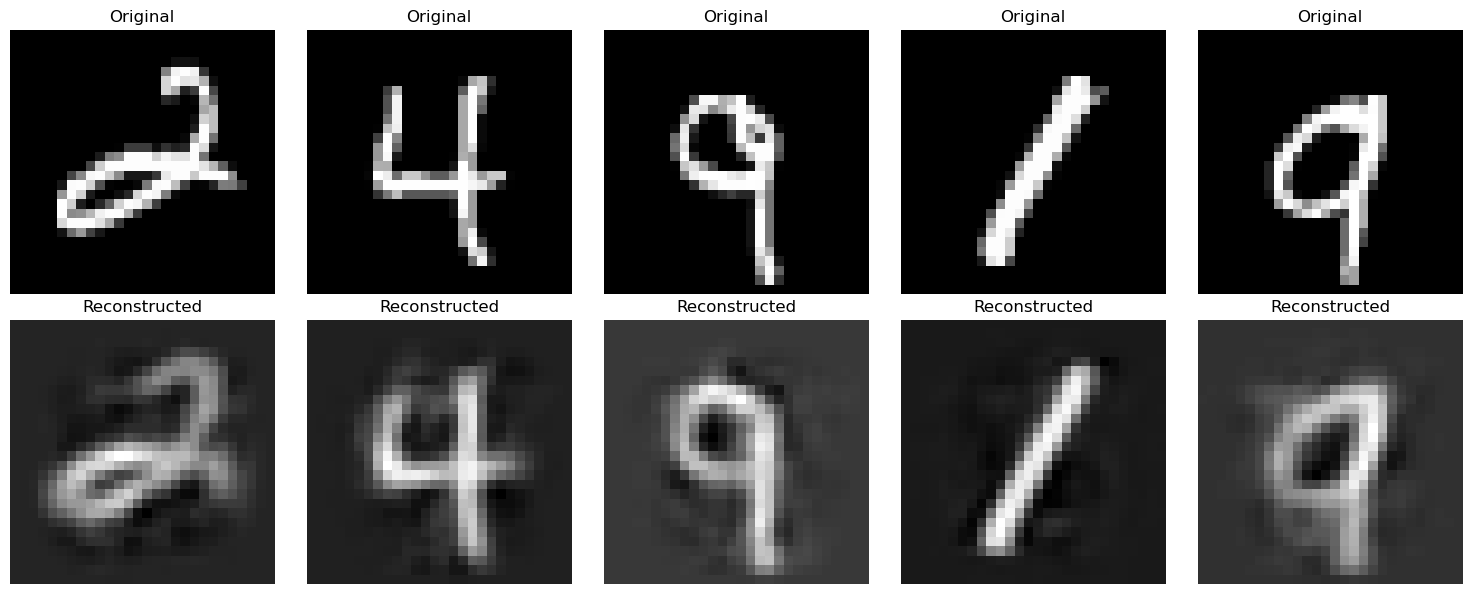

In [81]:
plot_images(overcomplete_model, train_dataloader, device, 5, False)

## Conclusion 
So in this blog post, we first saw the need for **Unsupervised Learning** techniques in the domain of feature learning, then we looked at a basic **Autoencoder** architecture, from there we finally built out the idea of a regularised **Sparse Autoencoder** and discussed the sparsity constraint in detail. 

I hope I was able to convery the need to regularise the vanilla autoencoder especially in the overcomplete case. Moreover, I hope the final generations for both the undercomplete and overcomplete networks provide a good idea of how powerful these autoencoders are. 

I will now be focusing on **Variational Autoencoders** in my next blog post and hopefully, we will be able to discover the generative capabilities of the VAEs! 

**PS: Before I sign off, you can access my repo for the Sparse Autoencoder [from here](https://github.com/KhaquanS/Sparse_Autoencoder) . You can simply run the sae.py file in your terminal to train your own SAE!**